In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.exceptions import ConvergenceWarning
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


## 03-04 data

In [56]:
# read NHANES data: Vitamin A, Vitamin E & Carotenoids 2005-2006
derm_2003 = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/derm_2003.XPT')
# Dermatology_questionaire
dermatology_questionaire = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/dermatology_questionaire.XPT')
# Alcohol
alcohol = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/alcohol.XPT')
# demo_2003
demo_2003 = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/demo_2003.XPT')
# body_measure
body_measure = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/body_measure.XPT')
# Vitimin_ace
vitamin_ace = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/vitamin_ace.XPT')
# use_of_supplements
use_of_supplements = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/use_of_supplements.XPT')
# smoking
smoking = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/smoking.XPT')
# vitimin_d
vitimin_d = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/vitimin_d.XPT')
# CRP
CRP = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/CRP.XPT')
# Supplement_count
supplement_count  = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/supplement_count.XPT')
# physical_activity
physical_activity = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/physical_activity.XPT')
# SMQMEC_C  smoke
SMQMEC_C = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/SMQMEC_C.XPT')
# immunization
immunization = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/immunization.XPT')

<ipython-input-56-42d5dd1f5c0a>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  derm_2003 = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/derm_2003.XPT')
<ipython-input-56-42d5dd1f5c0a>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  derm_2003 = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/derm_2003.XPT')


aggregate all data from 03-04

In [57]:

df_list_03 = [derm_2003,dermatology_questionaire,alcohol,demo_2003, body_measure,vitamin_ace, use_of_supplements, smoking, vitimin_d , CRP, supplement_count, physical_activity, SMQMEC_C, immunization]

merged_df_03 = df_list_03[0]

# Iterate through the list of DataFrames and join them based on 'common_column'
for df in df_list_03[1:]:
    merged_df_03 = pd.merge(merged_df_03, df, on='SEQN', how='left')

# Print the merged DataFrame
print('shape of merged_df', merged_df_03.shape)

# Check the number of null entries in each column
null_counts = merged_df_03.isnull().sum()



#only keep psoriasis related entries
df03 = merged_df_03[(merged_df_03['DEQ053']==1) | (merged_df_03['DEQ053']==2)]

# Display the resulting DataFrame
print('shape after drop', df03.shape)

#find target col
psoriasis_list = []
for index, row in df03.iterrows():
  if row['DEQ053'] == 1:
    psoriasis_list.append(1)
  else:
    psoriasis_list.append(0)
df03['psoriasis'] = psoriasis_list

df03['psoriasis'].value_counts()

shape of merged_df (10026, 364)
shape after drop (10011, 364)


<ipython-input-57-4990d1f10529>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df03['psoriasis'] = psoriasis_list


0    9710
1     301
Name: psoriasis, dtype: int64

## 05-06 data

In [58]:
bodymeasure_0506 = pd.read_sas('/content/drive/MyDrive/Capstone/data_0506/Bodymeasure_0506.xpt')
alcohol_0506 = pd.read_sas('/content/drive/MyDrive/Capstone/data_0506/alcohol_0506.xpt')
crp_0506 = pd.read_sas('/content/drive/MyDrive/Capstone/data_0506/CRP_0506.xpt')
demo_0506 = pd.read_sas('/content/drive/MyDrive/Capstone/data_0506/DEMO_0506.xpt')
derma_0506 = pd.read_sas('/content/drive/MyDrive/Capstone/data_0506/derma_0506.xpt')
immune_0506 = pd.read_sas('/content/drive/MyDrive/Capstone/data_0506/IMMUNE_0506.xpt')
smoking_0506 = pd.read_sas('/content/drive/MyDrive/Capstone/data_0506/Smoking_0506.xpt')
vitae_0506 = pd.read_sas('/content/drive/MyDrive/Capstone/data_0506/VITAE_0506.xpt')
vitd_0506 = pd.read_sas('/content/drive/MyDrive/Capstone/data_0506/VITD_0506.xpt')

In [59]:
df_list_05 =[bodymeasure_0506, alcohol_0506, crp_0506, demo_0506, derma_0506, immune_0506, smoking_0506, vitae_0506, vitd_0506]
merged_df_05 = df_list_05[0]

# Iterate through the list of DataFrames and join them based on 'common_column'
for df in df_list_05[1:]:
    merged_df_05 = pd.merge(merged_df_05, df, on='SEQN', how='left')

# Print the merged DataFrame
print('shape of merged_df', merged_df_05.shape)

#only keep psoriasis related entries
df05 = merged_df_05[(merged_df_05['DEQ053']==1) | (merged_df_05['DEQ053']==2)]


# Display the resulting DataFrame
print('shape after drop', df05.shape)

shape of merged_df (9950, 154)
shape after drop (3276, 154)


In [60]:
#find target col
psoriasis_list = []
for index, row in df05.iterrows():
  if row['DEQ053'] == 1:
    psoriasis_list.append(1)
  else:
    psoriasis_list.append(0)
df05['psoriasis'] = psoriasis_list

<ipython-input-60-3c14e7fdbcc8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df05['psoriasis'] = psoriasis_list


In [61]:
df05['psoriasis'].value_counts()

0    3193
1      83
Name: psoriasis, dtype: int64

## 13-14 data
no vitamin ace, crp


In [9]:
alcohol_1314 = pd.read_sas('/content/drive/MyDrive/Capstone/data_1314/Alcohol_1314.xpt')
bmi_1314 = pd.read_sas('/content/drive/MyDrive/Capstone/data_1314/BMI_1314.xpt')
demo_1314 = pd.read_sas('/content/drive/MyDrive/Capstone/data_1314/DEMO_1314.xpt')
# derm info in medical conditions questionnaire
derm_1314 = pd.read_sas('/content/drive/MyDrive/Capstone/data_1314/MCQ_H.xpt')
immune_1314 = pd.read_sas('/content/drive/MyDrive/Capstone/data_1314/Immune_1314.xpt')
smoking_1314 = pd.read_sas('/content/drive/MyDrive/Capstone/data_1314/Smoking_1314.xpt')
vitd_1314 = pd.read_sas('/content/drive/MyDrive/Capstone/data_1314/Vit_D_1314.xpt')

In [10]:
df_list_13 =[alcohol_1314, demo_1314, derm_1314, immune_1314, smoking_1314, vitd_1314]
merged_df_13 = df_list_13[0]

# Iterate through the list of DataFrames and join them based on 'common_column'
for df in df_list_13[1:]:
    merged_df_13 = pd.merge(merged_df_13, df, on='SEQN', how='left')

# Print the merged DataFrame
print('shape of merged_df', merged_df_13.shape)

# Check the number of null entries in each column
null_counts = merged_df_13.isnull().sum()


#only keep psoriasis related entries
df13 = merged_df_13[(merged_df_13['MCQ070']==1) | (merged_df_13['MCQ070']==2)]


# Display the resulting DataFrame
print('shape after drop', df13.shape)

shape of merged_df (5924, 196)
shape after drop (5918, 196)


In [11]:
#find target col
psoriasis_list = []
for index, row in df13.iterrows():
  if row['MCQ070'] == 1:
    psoriasis_list.append(1)
  else:
    psoriasis_list.append(0)
df13['psoriasis'] = psoriasis_list

<ipython-input-11-e92dadb96561>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df13['psoriasis'] = psoriasis_list


In [12]:
df13['psoriasis'].value_counts()

0    5769
1     149
Name: psoriasis, dtype: int64

## 11-12 data
no vitamin ace, crp

In [13]:
alcohol_1112 = pd.read_sas('/content/drive/MyDrive/Capstone/data_1112/Alcohol_1112.xpt')
bmi_1112 = pd.read_sas('/content/drive/MyDrive/Capstone/data_1112/BMI_1112.xpt')
demo_1112 = pd.read_sas('/content/drive/MyDrive/Capstone/data_1112/DEMO_1112.xpt')
# derm info in medical conditions questionnaire
derm_1112 = pd.read_sas('/content/drive/MyDrive/Capstone/data_1112/MCQ_G.xpt')
immune_1112 = pd.read_sas('/content/drive/MyDrive/Capstone/data_1112/immune_1112.xpt')
smoking_1112 = pd.read_sas('/content/drive/MyDrive/Capstone/data_1112/Smoking_1112.xpt')
vitd_1112 = pd.read_sas('/content/drive/MyDrive/Capstone/data_1112/VID_1112.xpt')

In [14]:
df_list_11 =[alcohol_1112, bmi_1112, demo_1112, derm_1112, immune_1112, smoking_1112, vitd_1112]
merged_df_11 = df_list_11[0]

# Iterate through the list of DataFrames and join them based on 'common_column'
for df in df_list_11[1:]:
    merged_df_11 = pd.merge(merged_df_11, df, on='SEQN', how='left')

# Print the merged DataFrame
print('shape of merged_df', merged_df_11.shape)

# Check the number of null entries in each column
null_counts = merged_df_11.isnull().sum()

#only keep psoriasis related entries
df11 = merged_df_11[(merged_df_11['MCQ070']==1) | (merged_df_11['MCQ070']==2)]

# Display the resulting DataFrame
print('shape after drop', df11.shape)

shape of merged_df (5615, 217)
shape after drop (5610, 217)


In [15]:
#find target col
psoriasis_list = []
for index, row in df11.iterrows():
  if row['MCQ070'] == 1:
    psoriasis_list.append(1)
  else:
    psoriasis_list.append(0)
df11['psoriasis'] = psoriasis_list

<ipython-input-15-2e50c9fcdf41>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df11['psoriasis'] = psoriasis_list


In [16]:
df11['psoriasis'].value_counts()

0    5458
1     152
Name: psoriasis, dtype: int64

## some more aggregations across the years

In [62]:
df03 = df03.rename(columns={"LBXATC": "LBXVIE", "LBDATCSI": "LBDVIESI"})

In [63]:
#find all columns that appear in all 4 dfs
# Extract the column names from each DataFrame
columns_df1 = set(df03.columns)
columns_df2 = set(df05.columns)

# Find the common columns among all DataFrames
common_columns = columns_df1.intersection(columns_df2)

# Convert the result to a list (if needed)
common_columns_list = list(common_columns)

# Print the common columns
print(common_columns_list)
print(len(common_columns_list))

['SMQ664W', 'LBDLUZSI', 'BMXSUB', 'SMD100NI', 'SMQ666C', 'DMDHRAGE', 'MIALANG', 'MIAINTRP', 'SDMVPSU', 'LBXBEC', 'LBXRPL', 'SMD055', 'SMD030', 'ALQ120Q', 'FIAPROXY', 'LBDRPLSI', 'BMXTRI', 'SIAPROXY', 'SMD100CO', 'DEQ055', 'SMQ666B', 'RIDAGEMN', 'DEQ034D', 'IMQ020', 'SMD100MN', 'SMQ670', 'DEQ036', 'LBXGTC', 'INDFMINC', 'DMDHHSIZ', 'LBDVIESI', 'LBDBECSI', 'DEQ057', 'SDMVSTRA', 'WTMEC2YR', 'SMQ666W', 'BMITRI', 'RIDAGEYR', 'SMD075', 'FIAINTRP', 'BMIWT', 'BMIARML', 'SMD100TR', 'DEQ034A', 'SMQ620', 'LBXRST', 'LBDVIASI', 'RIDEXMON', 'LBDVIDMS', 'SMQ666S', 'SMQ664M', 'SEQN', 'DMDHRMAR', 'MIAPROXY', 'DMDEDUC3', 'BMILEG', 'SMQ050Q', 'ALQ150', 'RIDAGEEX', 'LBXCRY', 'SMD641', 'RIDEXPRG', 'WTINT2YR', 'ALQ130', 'RIDRETH1', 'DEQ053', 'SMD100BR', 'LBDCBCSI', 'INDHHINC', 'DED031', 'LBDGTCSI', 'BMXBMI', 'LBXLYC', 'ALQ140U', 'RIAGENDR', 'DMDHSEDU', 'LBDALCSI', 'LBDRSTSI', 'SMD093', 'SMD650', 'SMD630', 'BMXARMC', 'SMQ666O', 'LBXVIA', 'LBDCRYSI', 'DMDMARTL', 'BMXWT', 'SIALANG', 'SDDSRVYR', 'DMQMILIT', 'BMX

In [65]:
df03 = df03[common_columns_list]
df05 = df05[common_columns_list]
df = pd.concat([df03, df05])
print(df.shape)

(13287, 149)


In [66]:
df['psoriasis'].value_counts()

0    12903
1      384
Name: psoriasis, dtype: int64

In [73]:
df_positive = df[df['psoriasis'] == 1]
df_negative = df[df['psoriasis'] == 0]


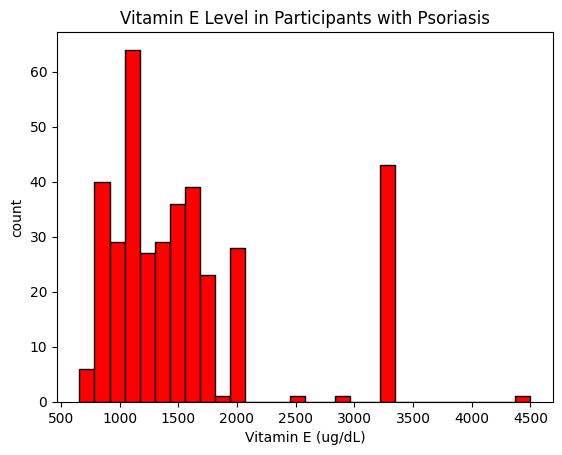

In [87]:
import matplotlib.pyplot as plt

# Plot a histogram for the 'Values' column
plt.hist(df_positive['LBXVIE'], bins=30, color='RED', edgecolor='black')

# Add labels and title
plt.xlabel('Vitamin E (ug/dL)')
plt.ylabel('count')
plt.title('Vitamin E Level in Participants with Psoriasis')

# Show the plot
plt.show()

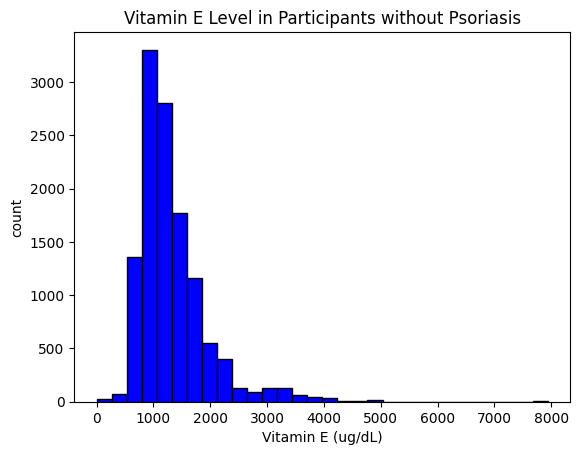

In [79]:
plt.hist(df_negative['LBXVIE'], bins=30, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Vitamin E (ug/dL)')
plt.ylabel('count')
plt.title('Vitamin E Level in Participants without Psoriasis')

# Show the plot
plt.show()

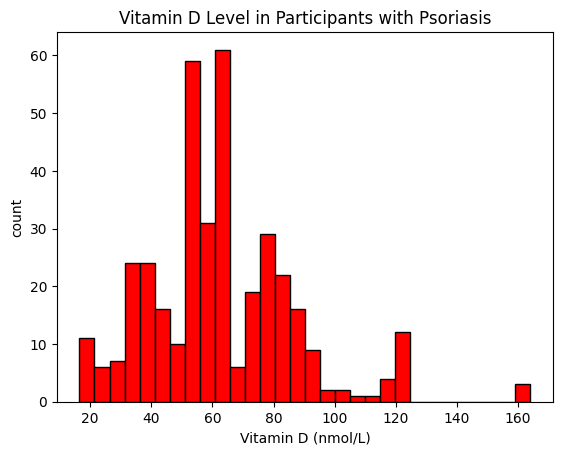

In [86]:
# Plot a histogram for the 'Values' column
plt.hist(df_positive['LBDVIDMS'], bins=30, color='RED', edgecolor='black')

# Add labels and title
plt.xlabel('Vitamin D (nmol/L)')
plt.ylabel('count')
plt.title('Vitamin D Level in Participants with Psoriasis')

# Show the plot
plt.show()

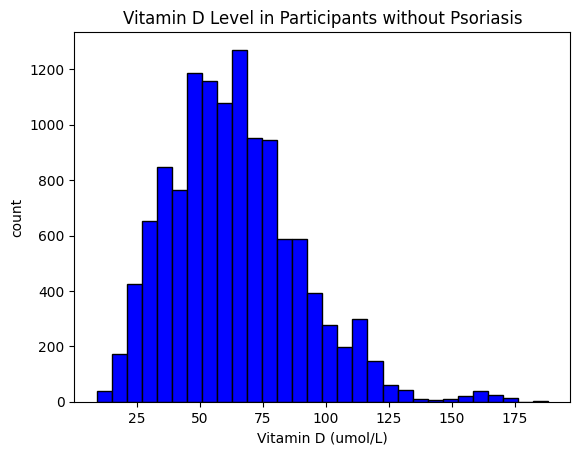

In [85]:
plt.hist(df_negative['LBDVIDMS'], bins=30, color='BLUE', edgecolor='black')

# Add labels and title
plt.xlabel('Vitamin D (umol/L)')
plt.ylabel('count')
plt.title('Vitamin D Level in Participants without Psoriasis')

# Show the plot
plt.show()

In [ ]:
#drop string columns

# Find and drop columns with string elements
string_columns = [col for col in df.columns if df[col].dtype == 'O']  # 'O' represents string dtype
df = df.drop(columns=string_columns)

# Display the DataFrame after dropping string columns
print(df.shape)

# Replace missing values with the mode for each column
df = df.fillna(df.mode().iloc[0])


(24815, 35)
